# Download data

In [1]:
import torch
dev = "cuda" if torch.cuda.is_available() else "cpu"
test_image_features = torch.load("/kaggle/input/aaaa2data/test_image_features_vitL.pt", map_location = torch.device(dev))
test_text_feature = torch.load("/kaggle/input/aaaa2data/test_text_feature_vitL.pt", map_location = torch.device(dev))
all_image_features = torch.load("/kaggle/input/aaaa2data/all_image_features_vitL.pt", map_location = torch.device(dev))
all_text_feature = torch.load("/kaggle/input/aaaa2data/all_text_feature_vitL.pt", map_location = torch.device(dev))
label_onehot_tensor = torch.load("/kaggle/input/aaaa2data/label_onehot_tensor.pt", map_location = torch.device(dev))

In [2]:
test_image_features.shape

torch.Size([10000, 768])

In [3]:
pip install openai-clip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.3 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368645 sha256=8068bb146e2565ab8d1ae44bc7753de53ea52051c9eb129f8ace9d7d39265e88
  Stored in directory: /root/.cache/pip/wheels/4d/28/91/808672ccb8e22af6e604b2e6c7b4324754ec3d237960f45a8e
Successfully built openai-clip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import clip
import torch
dev = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
from copy import deepcopy
import random

# Model

In [8]:
def add_weight_decay(model, weight_decay=1e-4, skip_list=()):
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue  # frozen weights
        if len(param.shape) == 1 or name.endswith(".bias") or name in skip_list:
            no_decay.append(param)
        else:
            decay.append(param)
    return [
        {'params': no_decay, 'weight_decay': 0.},
        {'params': decay, 'weight_decay': weight_decay}]

In [9]:
class ModelEma(torch.nn.Module):
    def __init__(self, model, decay=0.9997, device=None):
        super(ModelEma, self).__init__()
        # make a copy of the model for accumulating moving average of weights
        self.module = deepcopy(model)
        self.module.eval()
        self.decay = decay
        self.device = device  # perform ema on different device from model if set
        if self.device is not None:
            self.module.to(device=device)

    def _update(self, model, update_fn):
        with torch.no_grad():
            for ema_v, model_v in zip(self.module.state_dict().values(), model.state_dict().values()):
                if self.device is not None:
                    model_v = model_v.to(device=self.device)
                ema_v.copy_(update_fn(ema_v, model_v))

    def update(self, model):
        self._update(model, update_fn=lambda e, m: self.decay * e + (1. - self.decay) * m)

    def set(self, model):
        self._update(model, update_fn=lambda e, m: m)

In [10]:
import torch
import torch.nn as nn


class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=True):
        super(AsymmetricLoss, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        # Calculating Probabilities
        
        xs_pos = x
        xs_neg = 1 - x

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            loss *= one_sided_w

        return -loss.sum()


class AsymmetricLossOptimized(nn.Module):
    ''' Notice - optimized version, minimizes memory allocation and gpu uploading,
    favors inplace operations'''

    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False):
        super(AsymmetricLossOptimized, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

        # prevent memory allocation and gpu uploading every iteration, and encourages inplace operations
        self.targets = self.anti_targets = self.xs_pos = self.xs_neg = self.asymmetric_w = self.loss = None

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        self.targets = y
        self.anti_targets = 1 - y

        # Calculating Probabilities
        self.xs_pos = x
        self.xs_neg = 1.0 - x

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            self.xs_neg.add_(self.clip).clamp_(max=1)

        # Basic CE calculation
        self.loss = self.targets * torch.log(self.xs_pos.clamp(min=self.eps))
        self.loss.add_(self.anti_targets * torch.log(self.xs_neg.clamp(min=self.eps)))

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            self.xs_pos = self.xs_pos * self.targets
            self.xs_neg = self.xs_neg * self.anti_targets
            self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                          self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            self.loss *= self.asymmetric_w

        return -self.loss.sum()



In [30]:
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
from torchmetrics import F1Score
from torch import optim
from torch.cuda.amp import GradScaler, autocast
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
def Trainer(model, Data, epochs, epoch_step_1, epoch_step_2, lr = 1e-3,gamma_neg=0, gamma_pos=0, clip=0):
    ema = ModelEma(model, 0.97, device = dev)
    
    torch.manual_seed(5329)

    train_data = DataLoader(TensorDataset(Data[:25000], label_onehot_tensor[:25000]), batch_size=25000, shuffle = True)
    val_data = DataLoader(TensorDataset(Data[25000:], label_onehot_tensor[25000:].to(torch.int32)), batch_size=5000, shuffle = False)
    model = model.to(dev)
 
    weight_decay = 2e-4
    criterion = AsymmetricLossOptimized(gamma_neg=gamma_neg, gamma_pos=gamma_pos, clip=clip, disable_torch_grad_focal_loss=True)
    parameters = add_weight_decay(model, weight_decay)
    opti = optim.Adam(params=parameters, lr=lr, weight_decay=0)
    
    
    
    steps_per_epoch = len(train_data)
    #scheduler = lr_scheduler.OneCycleLR(opti, max_lr=lr, steps_per_epoch=steps_per_epoch, epochs=epochs,pct_start=0.2)
    
    
    
    
    scheduler = lr_scheduler.MultiStepLR(opti, milestones=[epoch_step_1,epoch_step_2], gamma = 0.1)
    f1 = F1Score(task="multilabel", num_labels = 18).to(dev)

    epoch = epochs
    loss_list = []
    f1_list = []
    scaler = GradScaler()

    for epoch in tqdm(range(epoch), colour = 'GREEN'):


        for data, label in train_data:   


    
            data, label = data.to(dev), label.to(dev)

            with autocast():  # mixed precision
                output = model(data).float() 


      
            loss = criterion(output, label)
            model.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(opti)
            scaler.update()
            scheduler.step()
            
            ema.update(model)

        loss_list.append(loss)
        if epoch % 50 == 0:
            with torch.autograd.no_grad():
                for data_val, label_val in val_data:
                    data_val, label_val = data_val.to(dev), label_val.to(dev)
                    predict = model(data_val)
                    f1_score = f1(predict, label_val)
                print('Validation F1 in epoch{} : {:.6f}'.format(epoch, f1_score))
            f1_list.append(f1_score)
    
    
    return model,ema,loss_list

In [25]:
import torch.nn as nn

class FEATURE_DECISION_DNN(nn.Module):
    def __init__(self, p = 0.5):
        super().__init__()
        self.fc1 = nn.Linear(768, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 18)
        self.dropout = nn.Dropout(p = p)

    def forward(self, inputs):
        tensor = F.gelu(self.fc1(inputs))
        tensor = self.dropout(tensor)
        tensor = F.gelu(self.fc2(tensor))
        tensor = self.dropout(tensor)
        tensor = torch.sigmoid(self.fc3(tensor))
        return tensor

class DECISION_DECISION_DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(18, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 18)

    def forward(self, inputs):
        tensor = F.gelu(self.fc1(inputs))
        tensor = F.gelu(self.fc2(tensor))
        tensor = torch.sigmoid(self.fc3(tensor))
        return tensor

In [ ]:
#BCE

###BCE

In [15]:
Net,ema_Net,loss_list = Trainer(FEATURE_DECISION_DNN(), all_image_features, 300, 200, 250, gamma_neg=0, gamma_pos=0,clip=0)
Net.eval()
with torch.autograd.no_grad():
    img_train = Net(all_image_features.to(dev))
    img_test = Net(test_image_features.to(dev))
    img_train_ema = ema_Net.module(all_image_features.to(dev))
    img_test_ema = ema_Net.module(test_image_features.to(dev))

  0%|          | 1/300 [00:02<10:15,  2.06s/it]

Validation F1 in epoch0 : 0.1454


  4%|▎         | 11/300 [00:05<01:52,  2.58it/s]

Validation F1 in epoch10 : 0.1456


  7%|▋         | 21/300 [00:09<01:53,  2.46it/s]

Validation F1 in epoch20 : 0.5786


 10%|█         | 31/300 [00:15<02:46,  1.62it/s]

Validation F1 in epoch30 : 0.5740


 14%|█▎        | 41/300 [00:22<02:44,  1.58it/s]

Validation F1 in epoch40 : 0.6649


 17%|█▋        | 51/300 [00:25<01:38,  2.53it/s]

Validation F1 in epoch50 : 0.7506


 20%|██        | 61/300 [00:29<01:39,  2.39it/s]

Validation F1 in epoch60 : 0.7855


 24%|██▎       | 71/300 [00:33<01:27,  2.61it/s]

Validation F1 in epoch70 : 0.8088


 27%|██▋       | 81/300 [00:37<01:30,  2.43it/s]

Validation F1 in epoch80 : 0.8203


 30%|███       | 91/300 [00:41<01:18,  2.66it/s]

Validation F1 in epoch90 : 0.8250


 34%|███▎      | 101/300 [00:45<01:25,  2.34it/s]

Validation F1 in epoch100 : 0.8326


 37%|███▋      | 111/300 [00:50<01:18,  2.40it/s]

Validation F1 in epoch110 : 0.8353


 40%|████      | 121/300 [00:54<01:16,  2.33it/s]

Validation F1 in epoch120 : 0.8381


 44%|████▎     | 131/300 [00:57<01:06,  2.54it/s]

Validation F1 in epoch130 : 0.8398


 47%|████▋     | 141/300 [01:01<01:06,  2.40it/s]

Validation F1 in epoch140 : 0.8406


 50%|█████     | 151/300 [01:05<00:58,  2.55it/s]

Validation F1 in epoch150 : 0.8462


 54%|█████▎    | 161/300 [01:09<00:56,  2.47it/s]

Validation F1 in epoch160 : 0.8450


 57%|█████▋    | 171/300 [01:13<00:47,  2.70it/s]

Validation F1 in epoch170 : 0.8442


 60%|██████    | 181/300 [01:17<00:51,  2.32it/s]

Validation F1 in epoch180 : 0.8483


 64%|██████▎   | 191/300 [01:21<00:44,  2.43it/s]

Validation F1 in epoch190 : 0.8433


 67%|██████▋   | 201/300 [01:25<00:41,  2.36it/s]

Validation F1 in epoch200 : 0.8461


 70%|███████   | 211/300 [01:29<00:35,  2.54it/s]

Validation F1 in epoch210 : 0.8459


 74%|███████▎  | 221/300 [01:33<00:32,  2.43it/s]

Validation F1 in epoch220 : 0.8462


 77%|███████▋  | 231/300 [01:37<00:25,  2.67it/s]

Validation F1 in epoch230 : 0.8459


 80%|████████  | 241/300 [01:41<00:24,  2.38it/s]

Validation F1 in epoch240 : 0.8473


 84%|████████▎ | 251/300 [01:45<00:18,  2.70it/s]

Validation F1 in epoch250 : 0.8431


 87%|████████▋ | 261/300 [01:49<00:16,  2.40it/s]

Validation F1 in epoch260 : 0.8469


 90%|█████████ | 271/300 [01:53<00:11,  2.44it/s]

Validation F1 in epoch270 : 0.8474


 94%|█████████▎| 281/300 [01:57<00:08,  2.33it/s]

Validation F1 in epoch280 : 0.8467


 97%|█████████▋| 291/300 [02:01<00:03,  2.50it/s]

Validation F1 in epoch290 : 0.8459


100%|██████████| 300/300 [02:04<00:00,  2.41it/s]


In [16]:
Net,ema_Net,loss_list= Trainer(FEATURE_DECISION_DNN(), all_text_feature, 300, 200, 250, gamma_neg=0, gamma_pos=0,clip=0)
Net.eval()
with torch.autograd.no_grad():
    txt_train = Net(all_text_feature.to(dev))
    txt_test = Net(test_text_feature.to(dev))
    txt_train_ema = ema_Net.module(all_text_feature.to(dev))
    txt_test_ema = ema_Net.module(test_text_feature.to(dev))

  0%|          | 1/300 [00:00<02:19,  2.15it/s]

Validation F1 in epoch0 : 0.1433


  4%|▎         | 11/300 [00:04<01:47,  2.68it/s]

Validation F1 in epoch10 : 0.1431


  7%|▋         | 21/300 [00:08<01:53,  2.46it/s]

Validation F1 in epoch20 : 0.5891


 10%|█         | 31/300 [00:12<01:39,  2.70it/s]

Validation F1 in epoch30 : 0.5317


 14%|█▎        | 41/300 [00:16<01:47,  2.42it/s]

Validation F1 in epoch40 : 0.6507


 17%|█▋        | 51/300 [00:20<01:42,  2.42it/s]

Validation F1 in epoch50 : 0.7462


 20%|██        | 61/300 [00:24<01:40,  2.37it/s]

Validation F1 in epoch60 : 0.7759


 24%|██▎       | 71/300 [00:27<01:28,  2.58it/s]

Validation F1 in epoch70 : 0.7952


 27%|██▋       | 81/300 [00:32<01:31,  2.40it/s]

Validation F1 in epoch80 : 0.8034


 30%|███       | 91/300 [00:35<01:17,  2.69it/s]

Validation F1 in epoch90 : 0.8102


 34%|███▎      | 101/300 [00:39<01:25,  2.32it/s]

Validation F1 in epoch100 : 0.8128


 37%|███▋      | 111/300 [00:43<01:10,  2.69it/s]

Validation F1 in epoch110 : 0.8161


 40%|████      | 121/300 [00:47<01:17,  2.31it/s]

Validation F1 in epoch120 : 0.8166


 44%|████▎     | 131/300 [00:51<01:09,  2.42it/s]

Validation F1 in epoch130 : 0.8209


 47%|████▋     | 141/300 [00:55<01:06,  2.38it/s]

Validation F1 in epoch140 : 0.8185


 50%|█████     | 151/300 [00:59<00:57,  2.58it/s]

Validation F1 in epoch150 : 0.8195


 54%|█████▎    | 161/300 [01:03<00:58,  2.39it/s]

Validation F1 in epoch160 : 0.8210


 57%|█████▋    | 171/300 [01:07<00:47,  2.71it/s]

Validation F1 in epoch170 : 0.8219


 60%|██████    | 181/300 [01:11<00:48,  2.46it/s]

Validation F1 in epoch180 : 0.8198


 64%|██████▎   | 191/300 [01:15<00:40,  2.70it/s]

Validation F1 in epoch190 : 0.8230


 67%|██████▋   | 201/300 [01:19<00:42,  2.30it/s]

Validation F1 in epoch200 : 0.8200


 70%|███████   | 211/300 [01:23<00:36,  2.47it/s]

Validation F1 in epoch210 : 0.8253


 74%|███████▎  | 221/300 [01:27<00:32,  2.41it/s]

Validation F1 in epoch220 : 0.8210


 77%|███████▋  | 231/300 [01:30<00:26,  2.60it/s]

Validation F1 in epoch230 : 0.8193


 80%|████████  | 241/300 [01:34<00:25,  2.33it/s]

Validation F1 in epoch240 : 0.8208


 84%|████████▎ | 251/300 [01:38<00:18,  2.68it/s]

Validation F1 in epoch250 : 0.8228


 87%|████████▋ | 261/300 [01:42<00:15,  2.49it/s]

Validation F1 in epoch260 : 0.8212


 90%|█████████ | 271/300 [01:46<00:11,  2.62it/s]

Validation F1 in epoch270 : 0.8229


 94%|█████████▎| 281/300 [01:50<00:08,  2.35it/s]

Validation F1 in epoch280 : 0.8214


 97%|█████████▋| 291/300 [01:54<00:03,  2.41it/s]

Validation F1 in epoch290 : 0.8207


100%|██████████| 300/300 [01:58<00:00,  2.54it/s]


In [17]:
sum_train = img_train+txt_train
sum_test = img_test+txt_test
sum_train_ema = img_train_ema+txt_train_ema
sum_test_ema = img_test_ema+txt_test_ema
Net, ema_Net,loss_list = Trainer(DECISION_DECISION_DNN(), sum_train, 300, 200, 250, gamma_neg=0, gamma_pos=0,clip=0)
Net.eval()
with torch.autograd.no_grad():
    final = Net(sum_test)
    final_ema = ema_Net.module(sum_test)

  0%|          | 1/300 [00:00<02:10,  2.30it/s]

Validation F1 in epoch0 : 0.0900


  4%|▎         | 11/300 [00:03<01:41,  2.84it/s]

Validation F1 in epoch10 : 0.0900


  7%|▋         | 21/300 [00:07<01:44,  2.66it/s]

Validation F1 in epoch20 : 0.5937


 10%|█         | 31/300 [00:10<01:32,  2.92it/s]

Validation F1 in epoch30 : 0.6493


 14%|█▎        | 41/300 [00:14<01:35,  2.71it/s]

Validation F1 in epoch40 : 0.7277


 17%|█▋        | 51/300 [00:18<01:24,  2.95it/s]

Validation F1 in epoch50 : 0.8002


 20%|██        | 61/300 [00:21<01:33,  2.56it/s]

Validation F1 in epoch60 : 0.8203


 24%|██▎       | 71/300 [00:25<01:34,  2.43it/s]

Validation F1 in epoch70 : 0.8386


 27%|██▋       | 81/300 [00:29<01:25,  2.56it/s]

Validation F1 in epoch80 : 0.8479


 30%|███       | 91/300 [00:32<01:16,  2.74it/s]

Validation F1 in epoch90 : 0.8541


 34%|███▎      | 101/300 [00:36<01:15,  2.65it/s]

Validation F1 in epoch100 : 0.8574


 37%|███▋      | 111/300 [00:39<01:03,  2.95it/s]

Validation F1 in epoch110 : 0.8594


 40%|████      | 121/300 [00:43<01:08,  2.61it/s]

Validation F1 in epoch120 : 0.8613


 44%|████▎     | 131/300 [00:46<00:57,  2.94it/s]

Validation F1 in epoch130 : 0.8613


 47%|████▋     | 141/300 [00:50<00:59,  2.65it/s]

Validation F1 in epoch140 : 0.8621


 50%|█████     | 151/300 [00:54<00:56,  2.61it/s]

Validation F1 in epoch150 : 0.8621


 54%|█████▎    | 161/300 [00:58<00:56,  2.47it/s]

Validation F1 in epoch160 : 0.8626


 57%|█████▋    | 171/300 [01:01<00:45,  2.83it/s]

Validation F1 in epoch170 : 0.8635


 60%|██████    | 181/300 [01:05<00:46,  2.55it/s]

Validation F1 in epoch180 : 0.8635


 64%|██████▎   | 191/300 [01:08<00:37,  2.94it/s]

Validation F1 in epoch190 : 0.8631


 67%|██████▋   | 201/300 [01:12<00:36,  2.68it/s]

Validation F1 in epoch200 : 0.8634


 70%|███████   | 211/300 [01:15<00:31,  2.84it/s]

Validation F1 in epoch210 : 0.8635


 74%|███████▎  | 221/300 [01:19<00:30,  2.63it/s]

Validation F1 in epoch220 : 0.8636


 77%|███████▋  | 231/300 [01:22<00:25,  2.76it/s]

Validation F1 in epoch230 : 0.8635


 80%|████████  | 241/300 [01:26<00:26,  2.24it/s]

Validation F1 in epoch240 : 0.8634


 84%|████████▎ | 251/300 [01:30<00:17,  2.78it/s]

Validation F1 in epoch250 : 0.8634


 87%|████████▋ | 261/300 [01:34<00:14,  2.69it/s]

Validation F1 in epoch260 : 0.8634


 90%|█████████ | 271/300 [01:37<00:10,  2.77it/s]

Validation F1 in epoch270 : 0.8634


 94%|█████████▎| 281/300 [01:41<00:06,  2.74it/s]

Validation F1 in epoch280 : 0.8634


 97%|█████████▋| 291/300 [01:44<00:02,  3.05it/s]

Validation F1 in epoch290 : 0.8634


100%|██████████| 300/300 [01:47<00:00,  2.78it/s]


In [ ]:
#focal

In [18]:
Net,ema_Net,loss_list = Trainer(FEATURE_DECISION_DNN(), all_image_features, 300, 200, 250, gamma_neg=3, gamma_pos=3,clip=0)
Net.eval()
with torch.autograd.no_grad():
    img_train = Net(all_image_features.to(dev))
    img_test = Net(test_image_features.to(dev))
    img_train_ema = ema_Net.module(all_image_features.to(dev))
    img_test_ema = ema_Net.module(test_image_features.to(dev))

  0%|          | 1/300 [00:00<02:23,  2.09it/s]

Validation F1 in epoch0 : 0.1345


  4%|▎         | 11/300 [00:04<01:54,  2.52it/s]

Validation F1 in epoch10 : 0.1336


  7%|▋         | 21/300 [00:08<01:55,  2.42it/s]

Validation F1 in epoch20 : 0.6949


 10%|█         | 31/300 [00:12<02:05,  2.15it/s]

Validation F1 in epoch30 : 0.7892


 14%|█▎        | 41/300 [00:16<01:45,  2.45it/s]

Validation F1 in epoch40 : 0.8162


 17%|█▋        | 51/300 [00:20<01:31,  2.72it/s]

Validation F1 in epoch50 : 0.8234


 20%|██        | 61/300 [00:24<01:37,  2.45it/s]

Validation F1 in epoch60 : 0.8325


 24%|██▎       | 71/300 [00:28<01:23,  2.75it/s]

Validation F1 in epoch70 : 0.8361


 27%|██▋       | 81/300 [00:31<01:29,  2.46it/s]

Validation F1 in epoch80 : 0.8382


 30%|███       | 91/300 [00:35<01:22,  2.52it/s]

Validation F1 in epoch90 : 0.8405


 34%|███▎      | 101/300 [00:39<01:22,  2.42it/s]

Validation F1 in epoch100 : 0.8412


 37%|███▋      | 111/300 [00:43<01:21,  2.31it/s]

Validation F1 in epoch110 : 0.8437


 40%|████      | 121/300 [00:47<01:13,  2.44it/s]

Validation F1 in epoch120 : 0.8434


 44%|████▎     | 131/300 [00:51<01:01,  2.74it/s]

Validation F1 in epoch130 : 0.8421


 47%|████▋     | 141/300 [00:55<01:03,  2.51it/s]

Validation F1 in epoch140 : 0.8401


 50%|█████     | 151/300 [00:58<00:54,  2.74it/s]

Validation F1 in epoch150 : 0.8434


 54%|█████▎    | 161/300 [01:02<00:56,  2.46it/s]

Validation F1 in epoch160 : 0.8387


 57%|█████▋    | 171/300 [01:06<00:50,  2.54it/s]

Validation F1 in epoch170 : 0.8391


 60%|██████    | 181/300 [01:10<00:50,  2.37it/s]

Validation F1 in epoch180 : 0.8438


 64%|██████▎   | 191/300 [01:14<00:49,  2.18it/s]

Validation F1 in epoch190 : 0.8419


 67%|██████▋   | 201/300 [01:18<00:42,  2.34it/s]

Validation F1 in epoch200 : 0.8378


 70%|███████   | 211/300 [01:22<00:32,  2.70it/s]

Validation F1 in epoch210 : 0.8411


 74%|███████▎  | 221/300 [01:26<00:31,  2.48it/s]

Validation F1 in epoch220 : 0.8393


 77%|███████▋  | 231/300 [01:30<00:25,  2.66it/s]

Validation F1 in epoch230 : 0.8393


 80%|████████  | 241/300 [01:34<00:24,  2.40it/s]

Validation F1 in epoch240 : 0.8379


 84%|████████▎ | 251/300 [01:37<00:19,  2.50it/s]

Validation F1 in epoch250 : 0.8394


 87%|████████▋ | 261/300 [01:41<00:16,  2.36it/s]

Validation F1 in epoch260 : 0.8383


 90%|█████████ | 271/300 [01:46<00:13,  2.22it/s]

Validation F1 in epoch270 : 0.8403


 94%|█████████▎| 281/300 [01:50<00:07,  2.43it/s]

Validation F1 in epoch280 : 0.8392


 97%|█████████▋| 291/300 [01:54<00:03,  2.63it/s]

Validation F1 in epoch290 : 0.8397


100%|██████████| 300/300 [01:57<00:00,  2.55it/s]


In [19]:
Net,ema_Net,loss_list= Trainer(FEATURE_DECISION_DNN(), all_text_feature, 300, 200, 250, gamma_neg=3, gamma_pos=3,clip=0)
Net.eval()
with torch.autograd.no_grad():
    txt_train = Net(all_text_feature.to(dev))
    txt_test = Net(test_text_feature.to(dev))
    txt_train_ema = ema_Net.module(all_text_feature.to(dev))
    txt_test_ema = ema_Net.module(test_text_feature.to(dev))

  0%|          | 1/300 [00:00<02:20,  2.13it/s]

Validation F1 in epoch0 : 0.1433


  4%|▎         | 11/300 [00:04<01:57,  2.46it/s]

Validation F1 in epoch10 : 0.1431


  7%|▋         | 21/300 [00:08<01:56,  2.40it/s]

Validation F1 in epoch20 : 0.7174


 10%|█         | 31/300 [00:12<01:47,  2.49it/s]

Validation F1 in epoch30 : 0.7788


 14%|█▎        | 41/300 [00:16<01:53,  2.27it/s]

Validation F1 in epoch40 : 0.7974


 17%|█▋        | 51/300 [00:20<01:47,  2.32it/s]

Validation F1 in epoch50 : 0.8100


 20%|██        | 61/300 [00:24<01:38,  2.43it/s]

Validation F1 in epoch60 : 0.8127


 24%|██▎       | 71/300 [00:28<01:25,  2.68it/s]

Validation F1 in epoch70 : 0.8141


 27%|██▋       | 81/300 [00:31<01:27,  2.49it/s]

Validation F1 in epoch80 : 0.8161


 30%|███       | 91/300 [00:35<01:17,  2.70it/s]

Validation F1 in epoch90 : 0.8125


 34%|███▎      | 101/300 [00:39<01:22,  2.41it/s]

Validation F1 in epoch100 : 0.8166


 37%|███▋      | 111/300 [00:43<01:15,  2.51it/s]

Validation F1 in epoch110 : 0.8177


 40%|████      | 121/300 [00:47<01:16,  2.34it/s]

Validation F1 in epoch120 : 0.8169


 44%|████▎     | 131/300 [00:51<01:13,  2.31it/s]

Validation F1 in epoch130 : 0.8189


 47%|████▋     | 141/300 [00:55<01:05,  2.42it/s]

Validation F1 in epoch140 : 0.8192


 50%|█████     | 151/300 [00:59<00:57,  2.59it/s]

Validation F1 in epoch150 : 0.8198


 54%|█████▎    | 161/300 [01:03<00:56,  2.46it/s]

Validation F1 in epoch160 : 0.8176


 57%|█████▋    | 171/300 [01:07<00:47,  2.71it/s]

Validation F1 in epoch170 : 0.8149


 60%|██████    | 181/300 [01:11<00:50,  2.36it/s]

Validation F1 in epoch180 : 0.8139


 64%|██████▎   | 191/300 [01:14<00:43,  2.50it/s]

Validation F1 in epoch190 : 0.8154


 67%|██████▋   | 201/300 [01:18<00:41,  2.39it/s]

Validation F1 in epoch200 : 0.8121


 70%|███████   | 211/300 [01:23<00:39,  2.25it/s]

Validation F1 in epoch210 : 0.8129


 74%|███████▎  | 221/300 [01:27<00:32,  2.41it/s]

Validation F1 in epoch220 : 0.8117


 77%|███████▋  | 231/300 [01:31<00:28,  2.43it/s]

Validation F1 in epoch230 : 0.8137


 80%|████████  | 241/300 [01:35<00:24,  2.44it/s]

Validation F1 in epoch240 : 0.8116


 84%|████████▎ | 251/300 [01:38<00:18,  2.70it/s]

Validation F1 in epoch250 : 0.8120


 87%|████████▋ | 261/300 [01:42<00:16,  2.42it/s]

Validation F1 in epoch260 : 0.8146


 90%|█████████ | 271/300 [01:46<00:11,  2.48it/s]

Validation F1 in epoch270 : 0.8122


 94%|█████████▎| 281/300 [01:50<00:08,  2.36it/s]

Validation F1 in epoch280 : 0.8137


 97%|█████████▋| 291/300 [01:54<00:04,  2.16it/s]

Validation F1 in epoch290 : 0.8118


100%|██████████| 300/300 [01:58<00:00,  2.53it/s]


In [20]:
sum_train = img_train+txt_train
sum_test = img_test+txt_test
sum_train_ema = img_train_ema+txt_train_ema
sum_test_ema = img_test_ema+txt_test_ema
Net, ema_Net,loss_list = Trainer(DECISION_DECISION_DNN(), sum_train, 300, 200, 250, gamma_neg=3, gamma_pos=3,clip=0)
Net.eval()
with torch.autograd.no_grad():
    final = Net(sum_test)
    final_ema = ema_Net.module(sum_test)

  0%|          | 1/300 [00:00<02:14,  2.23it/s]

Validation F1 in epoch0 : 0.1499


  4%|▎         | 11/300 [00:04<01:41,  2.86it/s]

Validation F1 in epoch10 : 0.1499


  7%|▋         | 21/300 [00:07<01:53,  2.46it/s]

Validation F1 in epoch20 : 0.6623


 10%|█         | 31/300 [00:11<01:31,  2.95it/s]

Validation F1 in epoch30 : 0.7972


 14%|█▎        | 41/300 [00:15<01:38,  2.64it/s]

Validation F1 in epoch40 : 0.8334


 17%|█▋        | 51/300 [00:18<01:37,  2.55it/s]

Validation F1 in epoch50 : 0.8493


 20%|██        | 61/300 [00:22<01:33,  2.55it/s]

Validation F1 in epoch60 : 0.8543


 24%|██▎       | 71/300 [00:26<01:34,  2.42it/s]

Validation F1 in epoch70 : 0.8578


 27%|██▋       | 81/300 [00:30<01:26,  2.53it/s]

Validation F1 in epoch80 : 0.8607


 30%|███       | 91/300 [00:33<01:11,  2.92it/s]

Validation F1 in epoch90 : 0.8621


 34%|███▎      | 101/300 [00:37<01:14,  2.69it/s]

Validation F1 in epoch100 : 0.8628


 37%|███▋      | 111/300 [00:40<01:04,  2.91it/s]

Validation F1 in epoch110 : 0.8631


 40%|████      | 121/300 [00:44<01:07,  2.65it/s]

Validation F1 in epoch120 : 0.8632


 44%|████▎     | 131/300 [00:47<01:02,  2.72it/s]

Validation F1 in epoch130 : 0.8638


 47%|████▋     | 141/300 [00:51<01:05,  2.41it/s]

Validation F1 in epoch140 : 0.8643


 50%|█████     | 151/300 [00:54<00:51,  2.88it/s]

Validation F1 in epoch150 : 0.8647


 54%|█████▎    | 161/300 [00:58<00:59,  2.34it/s]

Validation F1 in epoch160 : 0.8645


 57%|█████▋    | 171/300 [01:02<00:44,  2.88it/s]

Validation F1 in epoch170 : 0.8641


 60%|██████    | 181/300 [01:05<00:43,  2.75it/s]

Validation F1 in epoch180 : 0.8646


 64%|██████▎   | 191/300 [01:09<00:36,  3.03it/s]

Validation F1 in epoch190 : 0.8643


 67%|██████▋   | 201/300 [01:12<00:39,  2.52it/s]

Validation F1 in epoch200 : 0.8641


 70%|███████   | 211/300 [01:16<00:32,  2.77it/s]

Validation F1 in epoch210 : 0.8641


 74%|███████▎  | 221/300 [01:19<00:30,  2.59it/s]

Validation F1 in epoch220 : 0.8642


 77%|███████▋  | 231/300 [01:23<00:24,  2.84it/s]

Validation F1 in epoch230 : 0.8642


 80%|████████  | 241/300 [01:26<00:22,  2.61it/s]

Validation F1 in epoch240 : 0.8643


 84%|████████▎ | 251/300 [01:30<00:17,  2.72it/s]

Validation F1 in epoch250 : 0.8643


 87%|████████▋ | 261/300 [01:34<00:14,  2.70it/s]

Validation F1 in epoch260 : 0.8643


 90%|█████████ | 271/300 [01:37<00:09,  2.94it/s]

Validation F1 in epoch270 : 0.8643


 94%|█████████▎| 281/300 [01:41<00:07,  2.63it/s]

Validation F1 in epoch280 : 0.8643


 97%|█████████▋| 291/300 [01:44<00:03,  2.71it/s]

Validation F1 in epoch290 : 0.8643


100%|██████████| 300/300 [01:48<00:00,  2.77it/s]


In [ ]:
#asl

In [21]:
Net,ema_Net,loss_list = Trainer(FEATURE_DECISION_DNN(), all_image_features, 300, 200, 250, gamma_neg=4, gamma_pos=1,clip=0.05)
Net.eval()
with torch.autograd.no_grad():
    img_train = Net(all_image_features.to(dev))
    img_test = Net(test_image_features.to(dev))
    img_train_ema = ema_Net.module(all_image_features.to(dev))
    img_test_ema = ema_Net.module(test_image_features.to(dev))

  0%|          | 1/300 [00:00<02:23,  2.08it/s]

Validation F1 in epoch0 : 0.1345


  4%|▎         | 11/300 [00:04<01:59,  2.43it/s]

Validation F1 in epoch10 : 0.1336


  7%|▋         | 21/300 [00:08<02:07,  2.19it/s]

Validation F1 in epoch20 : 0.5158


 10%|█         | 31/300 [00:12<02:03,  2.17it/s]

Validation F1 in epoch30 : 0.6414


 14%|█▎        | 41/300 [00:16<01:47,  2.40it/s]

Validation F1 in epoch40 : 0.6588


 17%|█▋        | 51/300 [00:20<01:37,  2.55it/s]

Validation F1 in epoch50 : 0.6875


 20%|██        | 61/300 [00:24<01:39,  2.40it/s]

Validation F1 in epoch60 : 0.6908


 24%|██▎       | 71/300 [00:28<01:35,  2.41it/s]

Validation F1 in epoch70 : 0.6993


 27%|██▋       | 81/300 [00:32<01:51,  1.97it/s]

Validation F1 in epoch80 : 0.7105


 30%|███       | 91/300 [00:37<01:25,  2.45it/s]

Validation F1 in epoch90 : 0.7125


 34%|███▎      | 101/300 [00:41<01:23,  2.39it/s]

Validation F1 in epoch100 : 0.7184


 37%|███▋      | 111/300 [00:45<01:17,  2.44it/s]

Validation F1 in epoch110 : 0.7283


 40%|████      | 121/300 [00:49<01:12,  2.45it/s]

Validation F1 in epoch120 : 0.7288


 44%|████▎     | 131/300 [00:53<01:05,  2.58it/s]

Validation F1 in epoch130 : 0.7375


 47%|████▋     | 141/300 [00:57<01:05,  2.42it/s]

Validation F1 in epoch140 : 0.7439


 50%|█████     | 151/300 [01:01<01:00,  2.47it/s]

Validation F1 in epoch150 : 0.7513


 54%|█████▎    | 161/300 [01:05<00:59,  2.32it/s]

Validation F1 in epoch160 : 0.7627


 57%|█████▋    | 171/300 [01:08<00:50,  2.56it/s]

Validation F1 in epoch170 : 0.7705


 60%|██████    | 181/300 [01:12<00:49,  2.40it/s]

Validation F1 in epoch180 : 0.7728


 64%|██████▎   | 191/300 [01:17<00:45,  2.42it/s]

Validation F1 in epoch190 : 0.7693


 67%|██████▋   | 201/300 [01:21<00:40,  2.45it/s]

Validation F1 in epoch200 : 0.7803


 70%|███████   | 211/300 [01:25<00:33,  2.68it/s]

Validation F1 in epoch210 : 0.7800


 74%|███████▎  | 221/300 [01:29<00:33,  2.38it/s]

Validation F1 in epoch220 : 0.7776


 77%|███████▋  | 231/300 [01:32<00:27,  2.50it/s]

Validation F1 in epoch230 : 0.7774


 80%|████████  | 241/300 [01:36<00:25,  2.29it/s]

Validation F1 in epoch240 : 0.7805


 84%|████████▎ | 251/300 [01:40<00:19,  2.53it/s]

Validation F1 in epoch250 : 0.7830


 87%|████████▋ | 261/300 [01:44<00:16,  2.32it/s]

Validation F1 in epoch260 : 0.7799


 90%|█████████ | 271/300 [01:49<00:11,  2.42it/s]

Validation F1 in epoch270 : 0.7819


 94%|█████████▎| 281/300 [01:53<00:07,  2.46it/s]

Validation F1 in epoch280 : 0.7794


 97%|█████████▋| 291/300 [01:57<00:03,  2.70it/s]

Validation F1 in epoch290 : 0.7844


100%|██████████| 300/300 [02:00<00:00,  2.49it/s]


In [22]:
Net,ema_Net,loss_list= Trainer(FEATURE_DECISION_DNN(), all_text_feature, 300, 200, 250,  gamma_neg=4, gamma_pos=1,clip=0.05)
Net.eval()
with torch.autograd.no_grad():
    txt_train = Net(all_text_feature.to(dev))
    txt_test = Net(test_text_feature.to(dev))
    txt_train_ema = ema_Net.module(all_text_feature.to(dev))
    txt_test_ema = ema_Net.module(test_text_feature.to(dev))

  0%|          | 1/300 [00:00<02:22,  2.10it/s]

Validation F1 in epoch0 : 0.1433


  4%|▎         | 11/300 [00:04<01:56,  2.48it/s]

Validation F1 in epoch10 : 0.1431


  7%|▋         | 21/300 [00:08<02:01,  2.30it/s]

Validation F1 in epoch20 : 0.5299


 10%|█         | 31/300 [00:12<01:45,  2.56it/s]

Validation F1 in epoch30 : 0.6114


 14%|█▎        | 41/300 [00:16<01:46,  2.43it/s]

Validation F1 in epoch40 : 0.6081


 17%|█▋        | 51/300 [00:20<01:39,  2.49it/s]

Validation F1 in epoch50 : 0.6374


 20%|██        | 61/300 [00:24<01:36,  2.47it/s]

Validation F1 in epoch60 : 0.6371


 24%|██▎       | 71/300 [00:28<01:25,  2.69it/s]

Validation F1 in epoch70 : 0.6353


 27%|██▋       | 81/300 [00:32<01:33,  2.35it/s]

Validation F1 in epoch80 : 0.6426


 30%|███       | 91/300 [00:35<01:24,  2.48it/s]

Validation F1 in epoch90 : 0.6439


 34%|███▎      | 101/300 [00:39<01:29,  2.23it/s]

Validation F1 in epoch100 : 0.6496


 37%|███▋      | 111/300 [00:44<01:19,  2.38it/s]

Validation F1 in epoch110 : 0.6452


 40%|████      | 121/300 [00:48<01:27,  2.05it/s]

Validation F1 in epoch120 : 0.6490


 44%|████▎     | 131/300 [00:52<01:09,  2.45it/s]

Validation F1 in epoch130 : 0.6512


 47%|████▋     | 141/300 [00:56<01:05,  2.44it/s]

Validation F1 in epoch140 : 0.6566


 50%|█████     | 151/300 [01:00<00:57,  2.60it/s]

Validation F1 in epoch150 : 0.6532


 54%|█████▎    | 161/300 [01:05<00:59,  2.35it/s]

Validation F1 in epoch160 : 0.6545


 57%|█████▋    | 171/300 [01:08<00:52,  2.46it/s]

Validation F1 in epoch170 : 0.6600


 60%|██████    | 181/300 [01:12<00:52,  2.29it/s]

Validation F1 in epoch180 : 0.6683


 64%|██████▎   | 191/300 [01:16<00:43,  2.52it/s]

Validation F1 in epoch190 : 0.6695


 67%|██████▋   | 201/300 [01:21<00:49,  2.00it/s]

Validation F1 in epoch200 : 0.6723


 70%|███████   | 211/300 [01:25<00:34,  2.58it/s]

Validation F1 in epoch210 : 0.6750


 74%|███████▎  | 221/300 [01:29<00:32,  2.42it/s]

Validation F1 in epoch220 : 0.6743


 77%|███████▋  | 231/300 [01:32<00:26,  2.64it/s]

Validation F1 in epoch230 : 0.6750


 80%|████████  | 241/300 [01:36<00:25,  2.32it/s]

Validation F1 in epoch240 : 0.6738


 84%|████████▎ | 251/300 [01:40<00:21,  2.28it/s]

Validation F1 in epoch250 : 0.6751


 87%|████████▋ | 261/300 [01:44<00:16,  2.36it/s]

Validation F1 in epoch260 : 0.6750


 90%|█████████ | 271/300 [01:48<00:11,  2.51it/s]

Validation F1 in epoch270 : 0.6745


 94%|█████████▎| 281/300 [01:53<00:08,  2.21it/s]

Validation F1 in epoch280 : 0.6777


 97%|█████████▋| 291/300 [01:57<00:03,  2.48it/s]

Validation F1 in epoch290 : 0.6733


100%|██████████| 300/300 [02:00<00:00,  2.49it/s]


In [23]:
sum_train = img_train+txt_train
sum_test = img_test+txt_test
sum_train_ema = img_train_ema+txt_train_ema
sum_test_ema = img_test_ema+txt_test_ema
Net, ema_Net,loss_list = Trainer(DECISION_DECISION_DNN(), sum_train, 300, 200, 250, gamma_neg=4, gamma_pos=1,clip=0.05)
Net.eval()
with torch.autograd.no_grad():
    final = Net(sum_test)
    final_ema = ema_Net.module(sum_test)

  0%|          | 1/300 [00:00<02:06,  2.37it/s]

Validation F1 in epoch0 : 0.1656


  4%|▎         | 11/300 [00:03<01:37,  2.97it/s]

Validation F1 in epoch10 : 0.1656


  7%|▋         | 21/300 [00:07<01:47,  2.59it/s]

Validation F1 in epoch20 : 0.6365


 10%|█         | 31/300 [00:11<01:41,  2.66it/s]

Validation F1 in epoch30 : 0.7164


 14%|█▎        | 41/300 [00:14<01:39,  2.60it/s]

Validation F1 in epoch40 : 0.7854


 17%|█▋        | 51/300 [00:18<01:38,  2.53it/s]

Validation F1 in epoch50 : 0.8128


 20%|██        | 61/300 [00:22<01:41,  2.35it/s]

Validation F1 in epoch60 : 0.8223


 24%|██▎       | 71/300 [00:25<01:18,  2.90it/s]

Validation F1 in epoch70 : 0.8285


 27%|██▋       | 81/300 [00:29<01:21,  2.67it/s]

Validation F1 in epoch80 : 0.8323


 30%|███       | 91/300 [00:32<01:10,  2.95it/s]

Validation F1 in epoch90 : 0.8362


 34%|███▎      | 101/300 [00:36<01:15,  2.64it/s]

Validation F1 in epoch100 : 0.8395


 37%|███▋      | 111/300 [00:39<01:10,  2.69it/s]

Validation F1 in epoch110 : 0.8415


 40%|████      | 121/300 [00:43<01:10,  2.53it/s]

Validation F1 in epoch120 : 0.8433


 44%|████▎     | 131/300 [00:47<01:01,  2.76it/s]

Validation F1 in epoch130 : 0.8445


 47%|████▋     | 141/300 [00:50<00:59,  2.69it/s]

Validation F1 in epoch140 : 0.8461


 50%|█████     | 151/300 [00:54<00:59,  2.51it/s]

Validation F1 in epoch150 : 0.8473


 54%|█████▎    | 161/300 [00:58<00:51,  2.71it/s]

Validation F1 in epoch160 : 0.8478


 57%|█████▋    | 171/300 [01:01<00:43,  2.94it/s]

Validation F1 in epoch170 : 0.8487


 60%|██████    | 181/300 [01:05<00:45,  2.60it/s]

Validation F1 in epoch180 : 0.8492


 64%|██████▎   | 191/300 [01:08<00:39,  2.75it/s]

Validation F1 in epoch190 : 0.8494


 67%|██████▋   | 201/300 [01:12<00:38,  2.57it/s]

Validation F1 in epoch200 : 0.8503


 70%|███████   | 211/300 [01:15<00:32,  2.72it/s]

Validation F1 in epoch210 : 0.8502


 74%|███████▎  | 221/300 [01:19<00:29,  2.64it/s]

Validation F1 in epoch220 : 0.8502


 77%|███████▋  | 231/300 [01:23<00:23,  2.96it/s]

Validation F1 in epoch230 : 0.8503


 80%|████████  | 241/300 [01:27<00:23,  2.47it/s]

Validation F1 in epoch240 : 0.8505


 84%|████████▎ | 251/300 [01:30<00:17,  2.78it/s]

Validation F1 in epoch250 : 0.8505


 87%|████████▋ | 261/300 [01:34<00:15,  2.51it/s]

Validation F1 in epoch260 : 0.8505


 90%|█████████ | 271/300 [01:38<00:11,  2.51it/s]

Validation F1 in epoch270 : 0.8505


 94%|█████████▎| 281/300 [01:42<00:07,  2.49it/s]

Validation F1 in epoch280 : 0.8505


 97%|█████████▋| 291/300 [01:45<00:03,  2.75it/s]

Validation F1 in epoch290 : 0.8505


100%|██████████| 300/300 [01:48<00:00,  2.75it/s]


In [ ]:
# dropout experiment

In [39]:
p = 0.8
Net,ema_Net,loss_list = Trainer(FEATURE_DECISION_DNN(p), all_image_features, 300, 200, 250)
Net.eval()
with torch.autograd.no_grad():
    img_train = Net(all_image_features.to(dev))
    img_test = Net(test_image_features.to(dev))
    img_train_ema = ema_Net.module(all_image_features.to(dev))
    img_test_ema = ema_Net.module(test_image_features.to(dev))

Net,ema_Net,loss_list= Trainer(FEATURE_DECISION_DNN(p), all_text_feature, 300, 200, 250)
Net.eval()
with torch.autograd.no_grad():
    txt_train = Net(all_text_feature.to(dev))
    txt_test = Net(test_text_feature.to(dev))
    txt_train_ema = ema_Net.module(all_text_feature.to(dev))
    txt_test_ema = ema_Net.module(test_text_feature.to(dev))

sum_train = img_train+txt_train
sum_test = img_test+txt_test
sum_train_ema = img_train_ema+txt_train_ema
sum_test_ema = img_test_ema+txt_test_ema
Net, ema_Net,loss_list = Trainer(DECISION_DECISION_DNN(), sum_train, 300, 200, 250)
Net.eval()
with torch.autograd.no_grad():
    final = Net(sum_test)
    final_ema = ema_Net.module(sum_test)

  0%|          | 1/300 [00:00<02:27,  2.02it/s]

Validation F1 in epoch0 : 0.144583


 17%|█▋        | 51/300 [00:20<01:49,  2.28it/s]

Validation F1 in epoch50 : 0.698799


 34%|███▎      | 101/300 [00:40<01:16,  2.61it/s]

Validation F1 in epoch100 : 0.810508


 50%|█████     | 151/300 [01:00<01:04,  2.31it/s]

Validation F1 in epoch150 : 0.824263


 67%|██████▋   | 201/300 [01:20<00:46,  2.13it/s]

Validation F1 in epoch200 : 0.833184


 84%|████████▎ | 251/300 [01:39<00:19,  2.53it/s]

Validation F1 in epoch250 : 0.830191


  0%|          | 1/300 [00:00<02:26,  2.05it/s]

Validation F1 in epoch0 : 0.136602


 17%|█▋        | 51/300 [00:19<01:39,  2.49it/s]

Validation F1 in epoch50 : 0.703277


 34%|███▎      | 101/300 [00:39<01:21,  2.45it/s]

Validation F1 in epoch100 : 0.798573


 50%|█████     | 151/300 [00:59<01:03,  2.34it/s]

Validation F1 in epoch150 : 0.811341


 67%|██████▋   | 201/300 [01:19<00:40,  2.47it/s]

Validation F1 in epoch200 : 0.810780


 84%|████████▎ | 251/300 [01:39<00:18,  2.61it/s]

Validation F1 in epoch250 : 0.812766


  0%|          | 1/300 [00:00<02:18,  2.17it/s]

Validation F1 in epoch0 : 0.200788


 17%|█▋        | 51/300 [00:17<01:25,  2.91it/s]

Validation F1 in epoch50 : 0.779646


 34%|███▎      | 101/300 [00:36<01:18,  2.55it/s]

Validation F1 in epoch100 : 0.850406


 50%|█████     | 151/300 [00:53<00:52,  2.86it/s]

Validation F1 in epoch150 : 0.857979


 67%|██████▋   | 201/300 [01:11<00:37,  2.61it/s]

Validation F1 in epoch200 : 0.861578


 84%|████████▎ | 251/300 [01:29<00:18,  2.70it/s]

Validation F1 in epoch250 : 0.862022


100%|██████████| 300/300 [01:46<00:00,  2.81it/s]


In [31]:
# gelu 
# dropout 0
# 0.8595
losslist1 = loss_list

In [34]:
# dropout 0.2, rerun the above training code and set p = 0.2
# 0.862972
losslist2 = loss_list

In [36]:
# dropout 0.5, rerun the above training code and leave p as default
# 0.865542
losslist3 = loss_list

In [38]:
# dropout 0.6, rerun the above training code and set p = 0.6
#0.866067
losslist4 = loss_list

In [40]:
# dropout 0.8, rerun the above training code and set p = 0.8
#0.862022
losslist5 = loss_list

In [41]:
class FEATURE_DECISION_DNN2(nn.Module):
    def __init__(self, p = 0.5):
        super().__init__()
        self.fc1 = nn.Linear(768, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 18)
        self.dropout = nn.Dropout(p = p)

    def forward(self, inputs):
        tensor = F.leaky_relu(self.fc1(inputs))
        tensor = self.dropout(tensor)
        tensor = F.leaky_relu(self.fc2(tensor))
        tensor = self.dropout(tensor)
        tensor = torch.sigmoid(self.fc3(tensor))
        return tensor

class DECISION_DECISION_DNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(18, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 18)

    def forward(self, inputs):
        tensor = F.leaky_relu(self.fc1(inputs))
        tensor = F.leaky_relu(self.fc2(tensor))
        tensor = torch.sigmoid(self.fc3(tensor))
        return tensor

In [51]:
p = 0.8
Net,ema_Net,loss_list = Trainer(FEATURE_DECISION_DNN2(p), all_image_features, 300, 200, 250)
Net.eval()
with torch.autograd.no_grad():
    img_train = Net(all_image_features.to(dev))
    img_test = Net(test_image_features.to(dev))
    img_train_ema = ema_Net.module(all_image_features.to(dev))
    img_test_ema = ema_Net.module(test_image_features.to(dev))

Net,ema_Net,loss_list= Trainer(FEATURE_DECISION_DNN2(p), all_text_feature, 300, 200, 250)
Net.eval()
with torch.autograd.no_grad():
    txt_train = Net(all_text_feature.to(dev))
    txt_test = Net(test_text_feature.to(dev))
    txt_train_ema = ema_Net.module(all_text_feature.to(dev))
    txt_test_ema = ema_Net.module(test_text_feature.to(dev))

sum_train = img_train+txt_train
sum_test = img_test+txt_test
sum_train_ema = img_train_ema+txt_train_ema
sum_test_ema = img_test_ema+txt_test_ema
Net, ema_Net,loss_list = Trainer(DECISION_DECISION_DNN2(), sum_train, 300, 200, 250)
Net.eval()
with torch.autograd.no_grad():
    final = Net(sum_test)
    final_ema = ema_Net.module(sum_test)

  0%|          | 1/300 [00:00<02:37,  1.90it/s]

Validation F1 in epoch0 : 0.144574


 17%|█▋        | 51/300 [00:20<01:39,  2.50it/s]

Validation F1 in epoch50 : 0.660949


 34%|███▎      | 101/300 [00:41<01:29,  2.23it/s]

Validation F1 in epoch100 : 0.802457


 50%|█████     | 151/300 [01:01<01:05,  2.29it/s]

Validation F1 in epoch150 : 0.828690


 67%|██████▋   | 201/300 [01:21<00:37,  2.65it/s]

Validation F1 in epoch200 : 0.831952


 84%|████████▎ | 251/300 [01:41<00:21,  2.26it/s]

Validation F1 in epoch250 : 0.829188


  0%|          | 1/300 [00:00<02:46,  1.80it/s]

Validation F1 in epoch0 : 0.139554


 17%|█▋        | 51/300 [00:20<01:43,  2.39it/s]

Validation F1 in epoch50 : 0.659001


 34%|███▎      | 101/300 [00:40<01:19,  2.49it/s]

Validation F1 in epoch100 : 0.790738


 50%|█████     | 151/300 [01:00<01:03,  2.33it/s]

Validation F1 in epoch150 : 0.808006


 67%|██████▋   | 201/300 [01:20<00:38,  2.57it/s]

Validation F1 in epoch200 : 0.808051


 84%|████████▎ | 251/300 [01:41<00:22,  2.22it/s]

Validation F1 in epoch250 : 0.811303


  0%|          | 1/300 [00:00<02:18,  2.16it/s]

Validation F1 in epoch0 : 0.121652


 17%|█▋        | 51/300 [00:19<01:33,  2.67it/s]

Validation F1 in epoch50 : 0.775305


 34%|███▎      | 101/300 [00:37<01:26,  2.31it/s]

Validation F1 in epoch100 : 0.855925


 50%|█████     | 151/300 [00:55<00:56,  2.63it/s]

Validation F1 in epoch150 : 0.864353


 67%|██████▋   | 201/300 [01:14<00:38,  2.60it/s]

Validation F1 in epoch200 : 0.865006


 84%|████████▎ | 251/300 [01:33<00:16,  2.88it/s]

Validation F1 in epoch250 : 0.865158


100%|██████████| 300/300 [01:52<00:00,  2.68it/s]


In [43]:
# leaky relu 
# dropout 0
# 0.852694
losslist_a = loss_list

In [45]:
# dropout 0.2, rerun the above training code and set p = 0.2
#0.859274
losslist_b = loss_list

In [47]:
# dropout 0.5, rerun the above training code and leave p as default
#0.862667
losslist_c = loss_list

In [50]:
# dropout 0.6, rerun the above training code and set p = 0.6
#0.863489
losslist_d = loss_list

In [52]:
# dropout 0.8, rerun the above training code and set p = 0.8
#.865158
losslist_e = loss_list

In [ ]:
import pandas as pd
y_proba = final.cpu().numpy()

resl = []
for i in y_proba:
  a = [x+1 for x in range(len(i)) if i[x] > 0.5]
  for j in range(len(a)):
    if a[j] >=12:
      a[j] = a[j]+1
  resl.append(a)

test_pred = []
for lis in resl:
  a = [str(i) for i in lis]
  test_pred.append(" ".join(a))

# output_df = pd.DataFrame(test_pred, columns = ['Labels'])

# # The best model of our prediction data on kaggle is svm.
# # Select the prediction of svm model for output.
# output_df = pd.DataFrame(test_pred, columns = ['Labels'])
# output_df.to_csv('/content/Predicted_labels.csv')
# df.to_csv("/content/Predicted_labels.csv".format(str(output_df)), index= False)
# print

# make a csv file
df = pd.DataFrame(columns=["ImageID", "Labels"])
# Creating the Second Dataframe using dictionary
for index, value in enumerate(test_pred):
    df_temp = pd.DataFrame({"ImageID":"{}.jpg".format(30000+index), "Labels":" ".join([str(i) for i in [value]])}, index=[0])
    # for appending df_temp at the end of df
    df = pd.concat([df,df_temp], ignore_index = True)

#threshold too high there will be NA    
for i in range(10000):
    if df.loc[i,'Labels'] == '':
        p = np.argmax(np.array(final[i].cpu()))
            
        if (p >= 12):
            p = p+1
        df.loc[i,'Labels'] = p

df.to_csv("Predicted_labels.csv", index = False)

In [ ]:
for i in df.Labels:
    
    if type(i) == "int":
        print(99)

In [ ]:
df

In [69]:
def get_item_losslist(list):
    to_return  = []
    for i in list:
        to_return.append(i.item())
    return to_return

In [73]:
losslist1 = get_item_losslist(losslist1)
losslist2 = get_item_losslist(losslist2)
losslist3 = get_item_losslist(losslist3)
losslist4 = get_item_losslist(losslist4)
losslist5 = get_item_losslist(losslist5)
losslist_a = get_item_losslist(losslist_a)
losslist_b = get_item_losslist(losslist_b)
losslist_c = get_item_losslist(losslist_c)
losslist_d = get_item_losslist(losslist_d)
losslist_e = get_item_losslist(losslist_e)


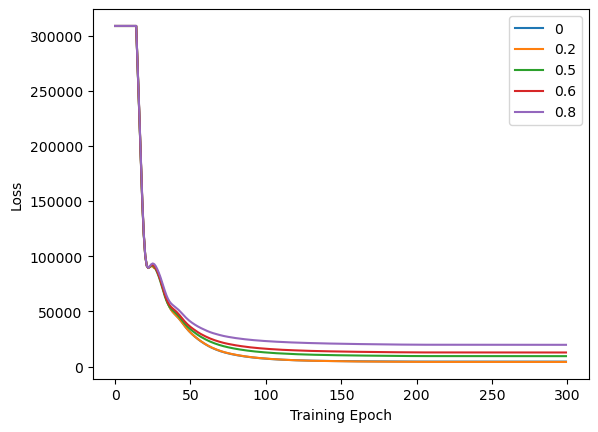

In [76]:
import matplotlib.pyplot as plt
plt.plot(losslist_a, label='0')
plt.plot(losslist_b, label='0.2')
plt.plot(losslist_c, label='0.5')
plt.plot(losslist_d, label='0.6')
plt.plot(losslist_e, label='0.8')

plt.xlabel('Training Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('dropout loss leaky.png')
plt.show()